# Prominent Edge - ticket status

Make sure to install seaborn and pandas modules

```sh
pip install seaborn pandas
```

In [12]:
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

from matplotlib import pyplot as plt

sns.set()
sns.set_style('whitegrid')
%matplotlib inline

## Reading data.

In [13]:
df = pd.read_csv('tickets.csv')
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
df.sort_values(by='created_at', ascending=False, inplace=True)

df.head()

,Unnamed: 0,id,subject,status_name,assigned_group,created_at,updated_at
0,0,1494,Contact request submitted,open,Unassigned,2018-02-08 16:33:18,2018-02-08 16:33:18
1,1,1493,User name & password,open,Unassigned,2018-02-08 16:30:12,2018-02-08 16:30:12
2,2,1492,FireCARES - Access.,open,Unassigned,2018-02-08 15:08:27,2018-02-08 15:08:27
3,3,1491,FireCARES - Access.,open,Unassigned,2018-02-08 14:56:27,2018-02-08 14:56:27
4,4,1490,Department administrator request - nealon.thom...,closed,Accounts,2018-02-08 06:08:27,2018-02-08 14:41:45


## Data processing

### Modified 'resolved' value to 'closed'

In [14]:
df.loc[df['status_name'] == 'closed', 'status_name'] = 'resolved'

### 1. Average first response time (TODO)

###  2. Average resolution/closed time

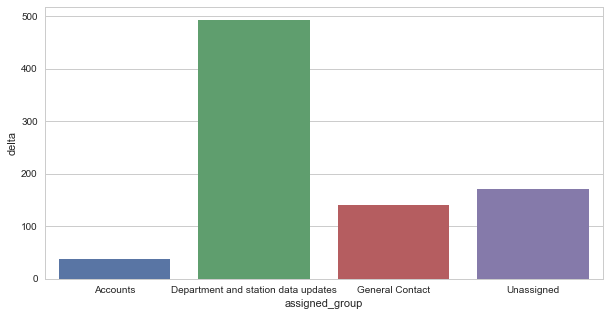

In [15]:
resolved_df = df.loc[(df['status_name'] == 'resolved')]
resolved_df['delta'] = abs(resolved_df['created_at'] - resolved_df['updated_at']).astype('timedelta64[h]')

reduced_df = resolved_df[['assigned_group', 'delta']]
assigned_means_df = reduced_df.groupby(['assigned_group']).mean().reset_index()

resolved_df.drop('delta', axis=1, inplace=True)

plt.figure(figsize=(10,5))
sns.barplot(assigned_means_df.assigned_group, assigned_means_df.delta);

### 3. Total count of tickets by status, by group

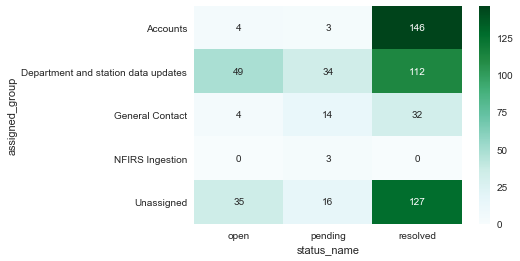

In [16]:
df_groups = df.groupby(['status_name', 'assigned_group']).size().reset_index(name='count')
df_heatmap = df_groups.pivot_table(index='assigned_group', columns='status_name', values='count', fill_value=0)
sns.heatmap(df_heatmap, annot=True, fmt="d", cmap='BuGn');

### 4. Weekly/monthly breakdown of new tickets by status by group (only last week/current week, last month/current month)

In [17]:
def create_delta_tickets(df, month=False):
    time_delta, freq = pd.to_timedelta(7, unit='d'), 'W-MON'
    if month:
        time_delta, freq = pd.to_timedelta(1, unit='M'), 'M'
    
    df['delta'] = df['created_at'] - time_delta
    group_by_list = ['assigned_group', 'status_name', pd.Grouper(key='delta', freq=freq)]
    df_dates_count = df.groupby(group_by_list).size().unstack().fillna(0).stack().reset_index(name='count').sort_values('delta')
    df_dates_count['delta'] = df_dates_count['delta'].dt.date
    
    condition = (df_dates_count['delta'] >= df_dates_count['delta'].unique()[-2])
    delta_tickets = df_dates_count.loc[condition]
    delta_tickets.sort_values(by=['assigned_group', 'status_name'], inplace=True)
    
    return delta_tickets

#### 4.1 Weekly

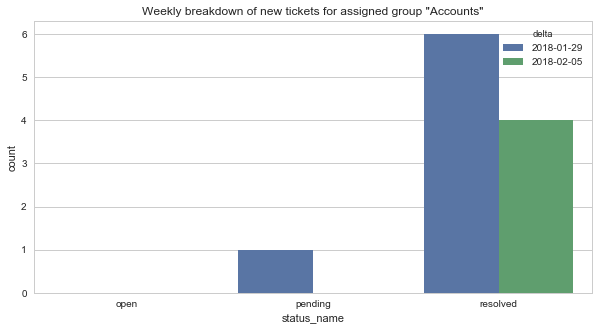

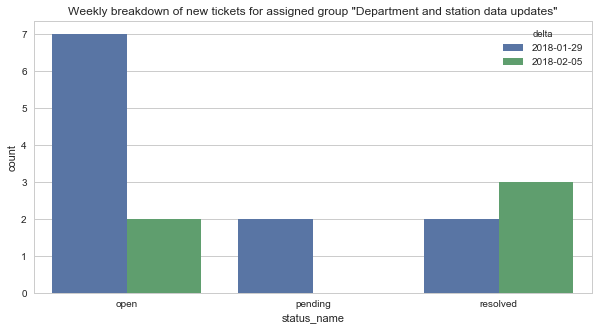

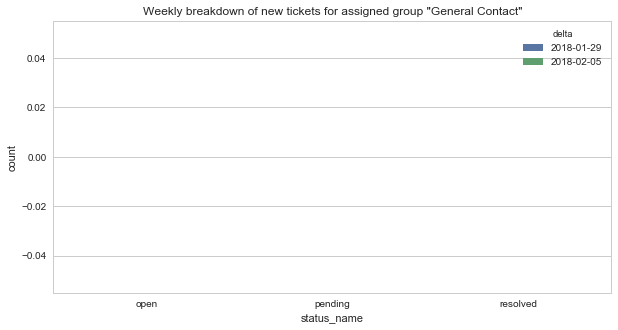

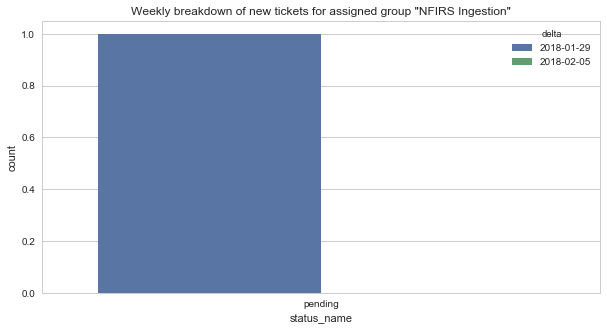

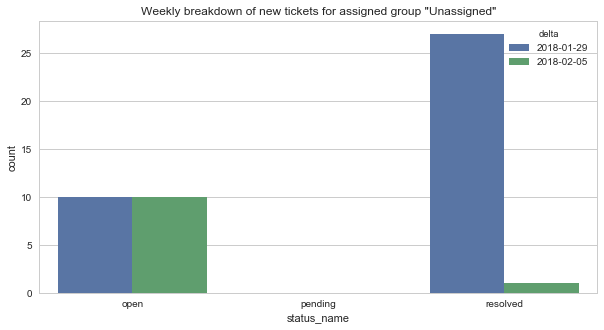

In [18]:
delta_tickets = create_delta_tickets(df)
assigned_groups = delta_tickets['assigned_group'].unique()
for assigned_group in assigned_groups:
    plt.figure(figsize=(10,5))
    assigned_df = delta_tickets.loc[(delta_tickets['assigned_group'] == assigned_group)]

    ax = sns.barplot(x="status_name", y="count", hue="delta", data=assigned_df)
    ax.set_title('Weekly breakdown of new tickets for assigned group "{0}"'.format(assigned_group))

#### 4.2 Monthly

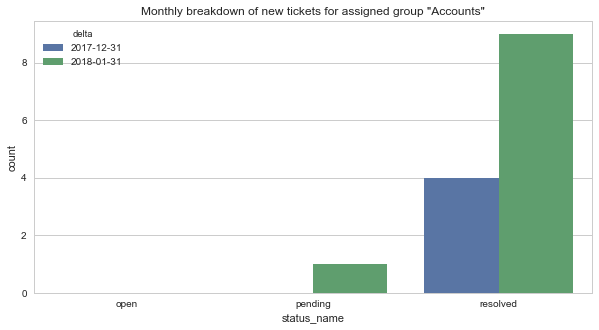

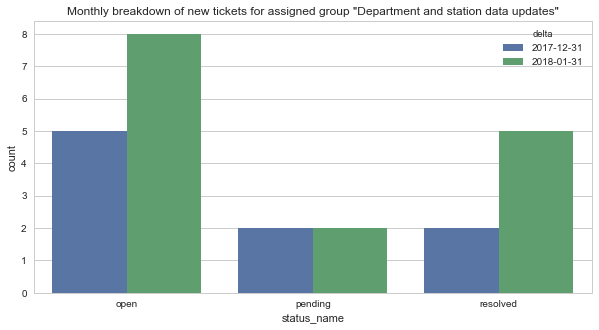

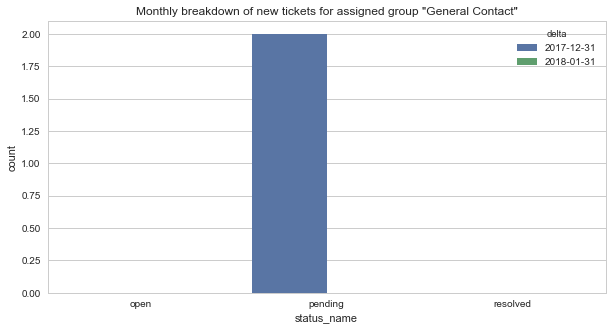

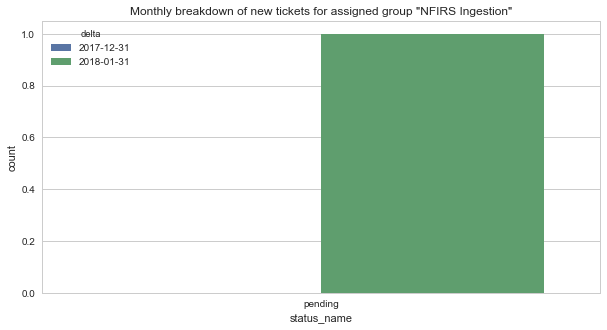

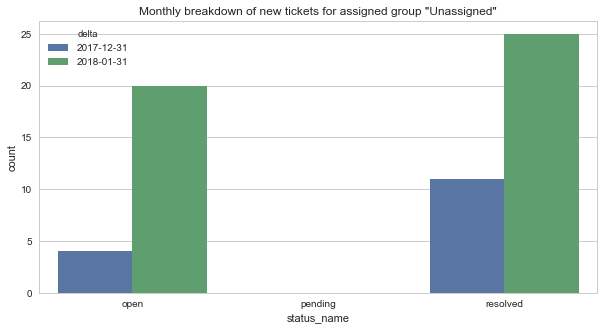

In [19]:
delta_tickets = create_delta_tickets(df, month=True)
assigned_groups = delta_tickets['assigned_group'].unique()
for assigned_group in assigned_groups:
    plt.figure(figsize=(10,5))
    assigned_df = delta_tickets.loc[(delta_tickets['assigned_group'] == assigned_group)]

    ax = sns.barplot(x="status_name", y="count", hue="delta", data=assigned_df)
    ax.set_title('Monthly breakdown of new tickets for assigned group "{0}"'.format(assigned_group))

## Measuring time for open tickets

For each group, we are going to select resolved tickets and measure average time for each week

In [21]:
not_closed_df = df.loc[(df['status_name'] != 'resolved')]
date_today = datetime.today()

not_closed_df['delta_days'] = abs(not_closed_df['created_at'] - date_today).astype('timedelta64[D]').astype('int')
not_closed_df.sort_values(by='delta_days', ascending=False, inplace=True)
not_closed_df.head()

,Unnamed: 0,id,subject,status_name,assigned_group,created_at,updated_at,delta,delta_days
546,546,112,Contact request submitted,pending,Unassigned,2017-04-25 14:46:36,2017-06-16 12:52:33,2017-03-26 04:17:30,295
540,540,127,Contact request submitted,open,Department and station data updates,2017-04-27 20:06:26,2017-08-11 13:33:41,2017-03-28 09:37:20,293
537,537,134,FireCARES - New feedback received.,pending,Unassigned,2017-04-28 18:54:13,2017-06-16 12:53:02,2017-03-29 08:25:07,292
535,535,148,Contact request submitted,pending,Unassigned,2017-05-01 16:18:03,2017-06-16 12:52:17,2017-04-01 05:48:57,289
533,533,153,Contact request submitted,pending,Unassigned,2017-05-01 17:32:37,2017-06-16 12:53:30,2017-04-01 07:03:31,289


In [23]:
delta_tickets = create_delta_tickets(df)
delta_tickets.head()

,assigned_group,status_name,delta,count
43,Accounts,open,2018-01-29,0.0
44,Accounts,open,2018-02-05,0.0
88,Accounts,pending,2018-01-29,1.0
89,Accounts,pending,2018-02-05,0.0
133,Accounts,resolved,2018-01-29,6.0
